# Random signals
### Author: Pawel Budzynski

In [2]:
import scipy.io.wavfile
import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.fft
import skimage.io
import skimage.color

In [3]:
sample_rate, sound = scipy.io.wavfile.read("noise1.wav")
IPython.display.Audio("noise1.wav")

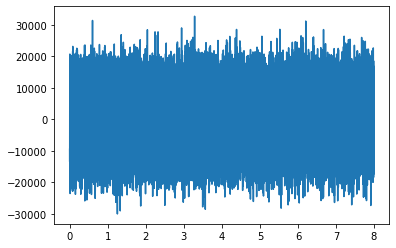

In [4]:
t_max = int(len(sound) / sample_rate)
t = np.linspace(0, t_max, len(sound))
plt.plot(t, sound)
plt.show()

Below there is a simple implementation approximating periodogram for one sample 
\begin{equation}
P_{x_{0}} = \frac{1}{N} |\hat{x}_{0}|^2.
\end{equation}

In [5]:
def my_periodogram(signal: np.ndarray) -> np.ndarray:
    """Simple periodogram implementation."""
    x_hat = scipy.fft.fft(signal)
    x_hat = scipy.fft.fftshift(x_hat)
    return np.abs(x_hat)**2 / signal.size

The result of simple periodogram seem to be correct though I didn't manage to find a way to calibrate axes to present meaningful values corresponding to the reality thus in the further part I will use existing implementations from libraries scipy and matplotlib. 

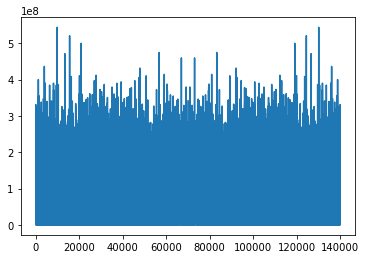

In [6]:
sample_rate, sound = scipy.io.wavfile.read("noise1.wav")
p = my_periodogram(sound)
plt.plot(p)
plt.show()

In [7]:
def spectrum_density(sound, sample_rate):
    """Use ready to use spectrum density estimators."""
    fig = plt.figure(figsize=(30, 20))
    
    x, period = scipy.signal.periodogram(sound, scaling='density', fs=sample_rate)
    plt.subplot(1, 3, 1)
    plt.plot(x, period)
    plt.title("Scipy periodogram.", fontsize=30)
#     plt.show()
    
    x, period = scipy.signal.welch(sound, scaling='density', fs=sample_rate)
    plt.subplot(1, 3, 2)
    plt.plot(x, period)
    plt.title("Scipy Welch.", fontsize=30)
#     plt.show()
    
    plt.subplot(1, 3, 3)
    plt.psd(sound)
    plt.title("Matplotlib Welch.", fontsize=30)
    plt.show()

The noise from the file "noise1.wav" is definitelly a white noise since all the frequencies stays on relatively similar level.

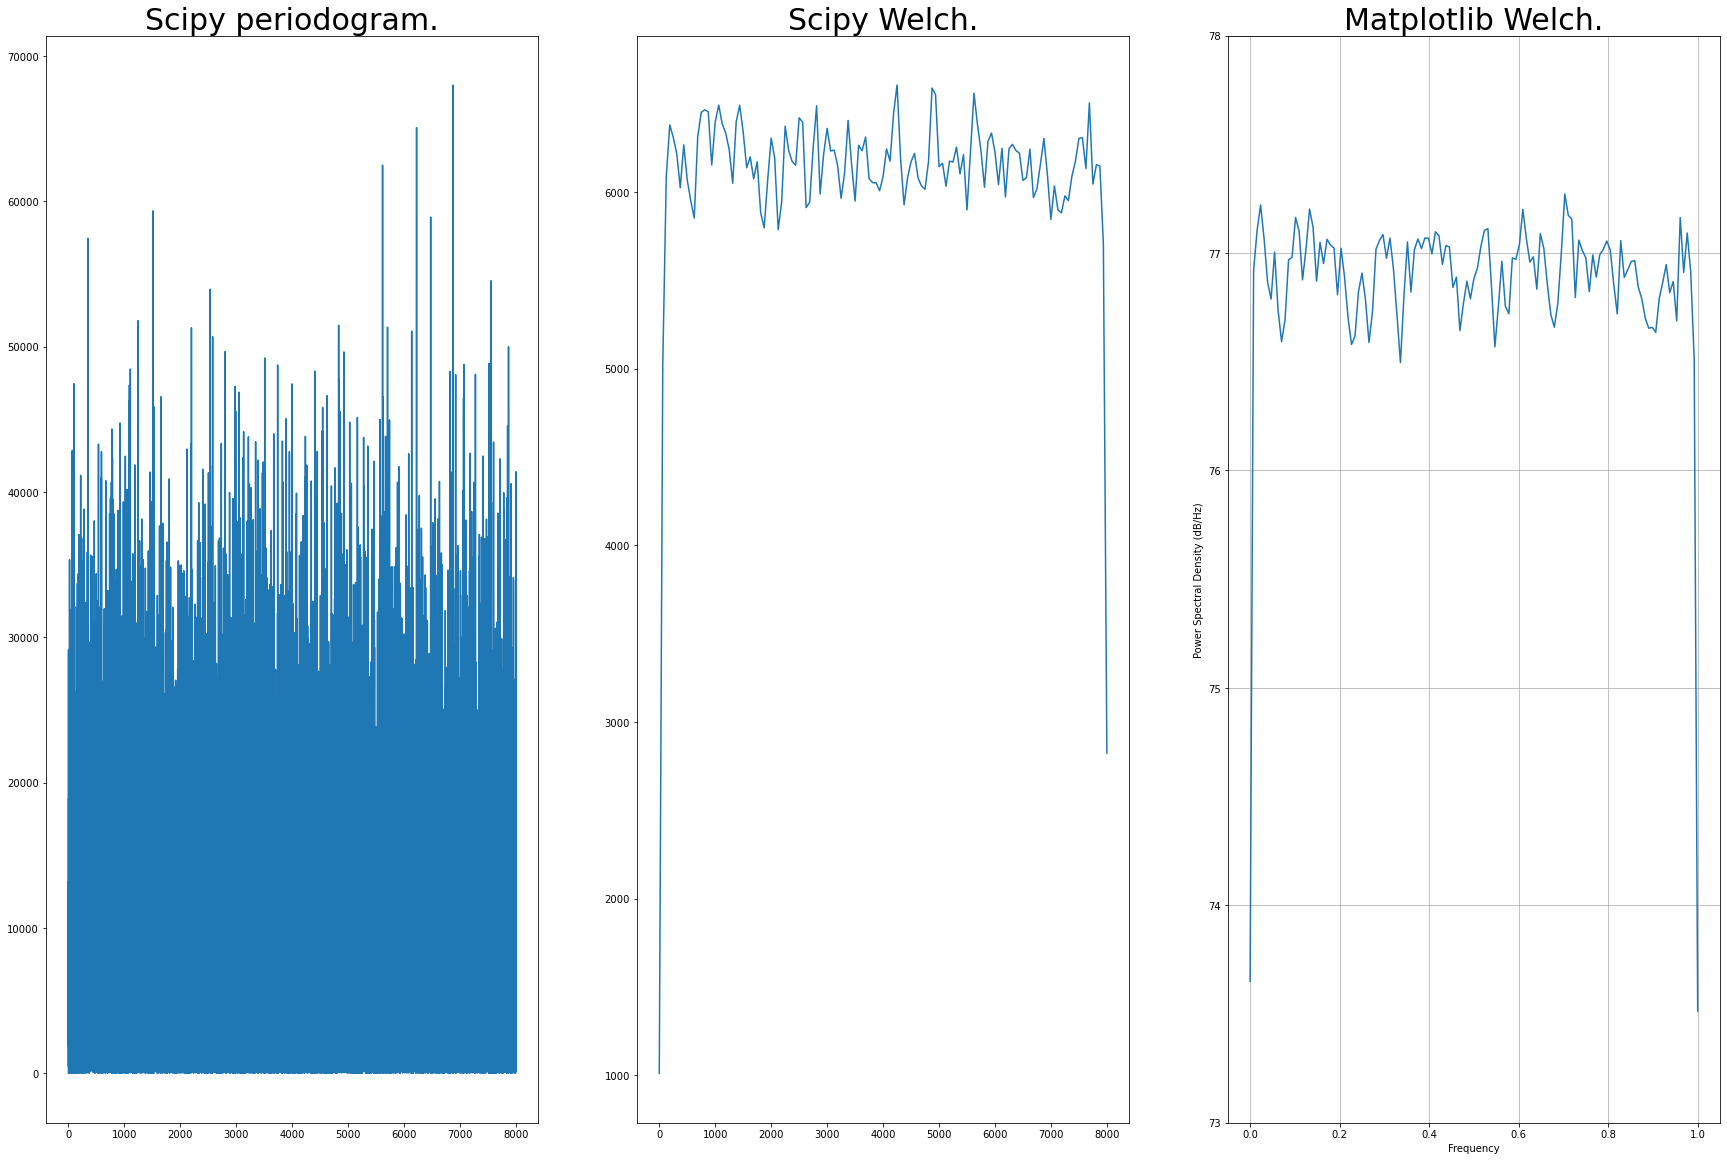

In [8]:
sample_rate, sound = scipy.io.wavfile.read("noise1.wav")
spectrum_density(sound, sample_rate)

Noise from the file "noise2.wav" is probably a brown noise as lower frequencies are more significant. 

In [ ]:
sample_rate, sound = scipy.io.wavfile.read("noise2.wav")
spectrum_density(sound, sample_rate)

Similarly to noise_2 noise_3 seems to be a brown noise. 

In [ ]:
sample_rate, sound = scipy.io.wavfile.read("noise3.wav")
spectrum_density(sound, sample_rate)

## Image denoising

In [ ]:
image = skimage.io.imread('barbara.jpg')
image = skimage.color.rgb2gray(image)

Signal to noise ration is given by the equation
\begin{equation}
SNR = 10 \cdot \log_{10} \left( \frac{||x||}{||x - y||} \right),
\end{equation}
where $||.||$ is L2 norm:
\begin{equation}
||x|| = \sum_{i=1}^{N} |x|^2.
\end{equation}

To generate a noise that results generates an image with given SNR we need to transform the equation that reurns noise standard deviation for a given SNR. 

\begin{equation}
10^{(\frac{SNR}{10})} = \frac{||x||}{||x - y||},
\end{equation}
\begin{equation}
||x - y|| = \frac{||x||}{10^{(\frac{SNR}{10})}}.
\end{equation}
Since $x-y$ is just the noise itself:
\begin{equation}
||x-y|| = \sum_{i=1}^{N} n_{i}^{2} = N \cdot \sigma^{2}_{n},
\end{equation}
because the mean of the noise is equal to $0$.

Hence the standard deviation of the noise can be get by 
\begin{equation}
\sigma_{n} = \sqrt{\frac{||x||}{N \cdot 10^{SNR/10}}}.
\end{equation}

In [ ]:
def snr(
    x: np.ndarray, 
    y: np.ndarray,
) -> float:
    """Compute Signal to noise ratio given original signal 
    and signal with a noise added."""
    return 10 * np.log10(np.sum(x**2) / np.sum((x - y)**2))

In [ ]:
def snr_to_n_var(
    snr: float, 
    signal: np.ndarray,
) -> float:
    """Compute noise variance for requested SNR."""
    N = np.size(signal)
    return np.sqrt(np.sum(signal**2) / (10**(snr / 10) * N))

In [ ]:
# Get sigma for requested SNR.
std = snr_to_n_var(snr=5, signal=image)
# Add white noise to the image.
image_noise = image + np.random.normal(loc=0, scale=std, size=image.shape)
# Compute SNR from original image and image with noise.
print("SNR: ", snr(image, image_noise), "dB")

# Show the generated images.
fig = plt.figure(figsize=(100, 50))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(image_noise, cmap="gray")
plt.title("With noise")

plt.show()

In [ ]:
def wiener_linear(
    signal: np.ndarray, 
    sigma: float,
) -> np.ndarray:
    """Simple implementation of linear Wiener filter. 
    WARNING: For some reason it's not working properly.
    Scipy implementation used in the next part of the code."""
    # Get number of samples.
    N = signal.size
    # Approximate periodogram for the only observation we have.
    P = np.abs(scipy.fft.fft2(signal))**2 *(1/N)
    # Compute filter in Fourier space and apply inverse transform.
    hw = np.real(scipy.fft.ifft2(P / (P + sigma**2)))
    # Apply the filter. Should be convolution?
    return signal * hw

# scipy.signal.convolve2d(image_noise, hw, 'same')
plt.imshow(wiener_linear(image_noise, std), cmap='gray')
plt.show()

In [ ]:
def compare_denoised(signal_to_noise: float):
    # Get noise sigma for requested SNR.
    std = snr_to_n_var(snr=signal_to_noise, signal=image)
    # Add white noise to the image.
    image_noise = image + np.random.normal(loc=0, scale=std, size=image.shape)
    # Compute SNR from original image and image with noise.
    print("SNR: ", snr(image, image_noise), "dB")
    
    fig = plt.figure(figsize=(50, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(image_noise, cmap='gray')
    plt.title("Image with noise.", fontsize=30)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image, cmap='gray')
    plt.title("Original image.", fontsize=30)
    
    plt.subplot(1, 3, 3)
    plt.imshow(scipy.signal.wiener(image_noise, mysize=(5, 5)), cmap='gray')
    plt.title("Denoised image.", fontsize=30)
    
    plt.show()

In [ ]:
for sig_to_noise in (20, 15, 10, 5, 0):
    compare_denoised(sig_to_noise)

The application of Wiener filter did not manage to reproduce original image from the noised one. Even for the small amount of noise the image has a lot of artifacts and has lost a lot of quality. 

## Music denoising

In [ ]:
music_sr, music = scipy.io.wavfile.read("music.wav")
IPython.display.Audio("music.wav")

In [ ]:
# Set sigma for the noises.
std = np.max(music) / 3

# Generate 3 noises. 
noise_1 = np.random.normal(loc=0, scale=std, size=music.shape)
noise_2 = np.random.normal(loc=0, scale=std, size=music.shape)
noise_3 = np.random.normal(loc=0, scale=std, size=music.shape)

# Create music with additive noise.
music_noise = music + 0.1*noise_1 + 0.1*noise_2 + 0.1*noise_3

# Save music with noise to a file. 
scipy.io.wavfile.write("music_noise.wav", music_sr, music_noise.astype(np.int16))
IPython.display.Audio("music_noise.wav")

In [ ]:
# Apply Oracle Wiener filter.
denoised = scipy.signal.wiener(music_noise, mysize=3)
scipy.io.wavfile.write("music_denoised.wav", music_sr, denoised.astype(np.int16))
IPython.display.Audio("music_denoised.wav")

After denoising the noise can still be heard very clearly. That may give a clue that Weiner filter is not the most effective one to use in such circumstances. Given the fact that the filter is based on expected values while we only have a one realisation of the signal it is not necesarily easy to use it. In it's original version Wiener filter requires a knowledge of the original signal which makes it a theoretical filter only, what is the reason to filter a noised signal if we have access to the original one. In the oracle implementation it uses a window for local mean and variation approximations what makes the implementation more useful. However the outcomes are still not outstanding.